In [18]:
# Cell 1: Load existing trained model (if present) and verify environment
import os
import gymnasium as gym
import ale_py  # ensure ALE namespace is registered
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

MODEL_PATH = os.path.join("models", "dqn_pong_cnn.zip")
ENV_ID = "ALE/Pong-v5"

# Recreate the same preprocessing used for CNN training: make_atari_env + 4-frame stack
try:
    env = make_atari_env(ENV_ID, n_envs=1, seed=42)
    env = VecFrameStack(env, n_stack=4)
except Exception as e:
    raise RuntimeError(
        f"Failed to build Atari VecEnv for {ENV_ID}. Ensure ale-py and ROMs are installed. Original error: {e}"
    )

if os.path.isfile(MODEL_PATH):
    model = DQN.load(MODEL_PATH, env=env)
    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=3)
    print(f"Loaded model from {MODEL_PATH}. Eval reward over 3 episodes: {mean_r:.2f} ± {std_r:.2f}")
else:
    model = None
    print(f"No existing model found at {MODEL_PATH}. You can still run experiments below.")

env.close()

Wrapping the env in a VecTransposeImage.
Loaded model from models\dqn_pong_cnn.zip. Eval reward over 3 episodes: -17.00 ± 1.63


In [19]:
# Cell 2: Reusable training function for hyperparameter experiments (CNN policy)
import time
import pandas as pd
from typing import Dict, Tuple

from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

# Callback to record episode stats into a unique CSV per run
class EpisodeCSVLogger(BaseCallback):
    def __init__(self, csv_path: str, verbose: int = 0):
        super().__init__(verbose)
        self.csv_path = csv_path
        self.rows = []

    def _on_step(self) -> bool:
        # VecEnv infos may contain 'episode' dict on episode end
        for info in self.locals.get("infos", []):
            if "episode" in info:
                ep = info["episode"]
                self.rows.append((self.num_timesteps, ep.get("l", None), ep.get("r", None)))
        return True

    def _on_training_end(self) -> None:
        import csv, os
        os.makedirs(os.path.dirname(self.csv_path), exist_ok=True)
        with open(self.csv_path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["timestep", "ep_length", "ep_reward"]) 
            w.writerows(self.rows)
        if self.verbose:
            print(f"Saved episode CSV to {self.csv_path}")


def make_cnn_env(seed: int):
    env = make_atari_env(ENV_ID, n_envs=1, seed=seed)
    env = VecFrameStack(env, n_stack=4)
    return env


def train_experiment(name: str, hp: Dict, total_timesteps: int = 50_000, seed: int = 42, eval_episodes: int = 3) -> Tuple[Dict, DQN]:
    """Train a DQN(CnnPolicy) model with given hyperparameters.
    Returns (metrics_dict, model) WITHOUT saving the model; caller decides which to persist.
    hp is a dict of DQN constructor keyword args (learning_rate, gamma, batch_size, etc.).
    """
    import os
    os.makedirs("logs", exist_ok=True)
    os.makedirs("models", exist_ok=True)  # ensure exists for later best-model save

    env = make_cnn_env(seed)
    csv_log = os.path.join("logs", f"training_metrics_{name}.csv")
    callback = EpisodeCSVLogger(csv_log, verbose=0)

    model = DQN(
        "CnnPolicy",
        env,
        seed=seed,
        tensorboard_log=os.path.join("logs", "tensorboard", name),
        **hp,
    )

    print(f"\n[RUN {name}] Training {total_timesteps} steps | hp={hp}")
    t0 = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)
    minutes = (time.time() - t0) / 60.0

    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=eval_episodes)
    env.close()

    metrics = {
        "name": name,
        "mean_reward": float(mean_r),
        "std_reward": float(std_r),
        "train_minutes": minutes,
        **hp,
    }
    print(f"[RUN {name}] Finished: mean_reward={mean_r:.2f} ± {std_r:.2f} | train_minutes={minutes:.2f}")
    return metrics, model

print("Training function ready. Configure hyperparameter sets in next cell.")

Training function ready. Configure hyperparameter sets in next cell.


In [20]:
# Cell 3: Define TEN hyperparameter experiment configurations (CNN policy)
# Expanded from 5 to 10 for broader tuning coverage.
# Strategy: vary learning rate, buffer size, batch size, gamma, exploration schedule, and target update interval.

experiments = [
    # 1. New Baseline (moderate)
    {
        "name": "exp1_new_baseline",
        "hp": dict(
            learning_rate=1.25e-4,
            gamma=0.99,
            batch_size=32,
            buffer_size=100_000,
            train_freq=4,
            gradient_steps=1,
            target_update_interval=8_000,
            exploration_fraction=0.1,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.02,
            verbose=0,
        ),
    },
    # # 2. High learning rate + smaller buffer (faster adaptation)
    # {
    #     "name": "exp2_fast_adaptation",
    #     "hp": dict(
    #         learning_rate=4e-4,
    #         gamma=0.98,
    #         batch_size=32,
    #         buffer_size=50_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=5_000,
    #         exploration_fraction=0.15,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.05,
    #         verbose=0,
    #     ),
    # },
    # # 3. Low learning rate + large buffer (slow and stable)
    # {
    #     "name": "exp3_slow_stable",
    #     "hp": dict(
    #         learning_rate=5e-5,
    #         gamma=0.995,
    #         batch_size=64,
    #         buffer_size=250_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=15_000,
    #         exploration_fraction=0.1,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.01,
    #         verbose=0,
    #     ),
    # },
    # # 4. Fast target updates + higher gamma
    # {
    #     "name": "exp4_fast_target_high_gamma",
    #     "hp": dict(
    #         learning_rate=1.5e-4,
    #         gamma=0.997,
    #         batch_size=32,
    #         buffer_size=120_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=3_000,
    #         exploration_fraction=0.12,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.02,
    #         verbose=0,
    #     ),
    # },
    # # 5. Aggressive exploration decay (short fraction)
    # {
    #     "name": "exp5_aggressive_decay",
    #     "hp": dict(
    #         learning_rate=1e-4,
    #         gamma=0.99,
    #         batch_size=32,
    #         buffer_size=100_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=10_000,
    #         exploration_fraction=0.05,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.01,
    #         verbose=0,
    #     ),
    # },
    # # 6. Large batch + moderate learning rate
    # {
    #     "name": "exp6_large_batch_moderate_lr",
    #     "hp": dict(
    #         learning_rate=2e-4,
    #         gamma=0.99,
    #         batch_size=128,
    #         buffer_size=150_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=10_000,
    #         exploration_fraction=0.1,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.02,
    #         verbose=0,
    #     ),
    # },
    # # 7. Frequent training (train every step)
    # {
    #     "name": "exp7_train_every_step",
    #     "hp": dict(
    #         learning_rate=1e-4,
    #         gamma=0.99,
    #         batch_size=16,
    #         buffer_size=80_000,
    #         train_freq=1,
    #         gradient_steps=1,
    #         target_update_interval=10_000,
    #         exploration_fraction=0.15,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.02,
    #         verbose=0,
    #     ),
    # },
    # # 8. High gradient steps per update (more optimization per batch)
    # {
    #     "name": "exp8_multi_gradient_steps",
    #     "hp": dict(
    #         learning_rate=1e-4,
    #         gamma=0.99,
    #         batch_size=32,
    #         buffer_size=100_000,
    #         train_freq=4,
    #         gradient_steps=8,
    #         target_update_interval=10_000,
    #         exploration_fraction=0.1,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.01,
    #         verbose=0,
    #     ),
    # },
    # # 9. High gamma, large buffer, slower exploration decay
    # {
    #     "name": "exp9_high_gamma_slow_decay",
    #     "hp": dict(
    #         learning_rate=1e-4,
    #         gamma=0.999,
    #         batch_size=32,
    #         buffer_size=200_000,
    #         train_freq=4,
    #         gradient_steps=1,
    #         target_update_interval=12_000,
    #         exploration_fraction=0.2,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.02,
    #         verbose=0,
    #     ),
    # },
    # # 10. Lower gamma, faster updates (short-term learner)
    # {
    #     "name": "exp10_low_gamma_fast_updates",
    #     "hp": dict(
    #         learning_rate=2e-4,
    #         gamma=0.97,
    #         batch_size=32,
    #         buffer_size=100_000,
    #         train_freq=2,
    #         gradient_steps=1,
    #         target_update_interval=4_000,
    #         exploration_fraction=0.1,
    #         exploration_initial_eps=1.0,
    #         exploration_final_eps=0.03,
    #         verbose=0,
    #     ),
    # },
]

print(f"Prepared {len(experiments)} experiment configs.")

Prepared 1 experiment configs.


In [ ]:
# Cell 4: Run experiments, keep ONLY the best model, and build results table
import os
import pandas as pd

TOTAL_TIMESTEPS = 50_000  # increase for better learning (e.g., 500_000 or more)
SEED = 42
EVAL_EPISODES = 3

results = []
best_record = None
best_mean_reward = None

# Automatically derive model save path from the experiment name
current_exp_name = experiments[0]["name"]  # since you keep only one active experiment
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
best_model_path = os.path.join(model_dir, f"{current_exp_name}_best.zip")

for exp in experiments:
    metrics, model = train_experiment(
        name=exp["name"],
        hp=exp["hp"],
        total_timesteps=TOTAL_TIMESTEPS,
        seed=SEED,
        eval_episodes=EVAL_EPISODES,
    )
    results.append(metrics)

    if (best_mean_reward is None) or (metrics["mean_reward"] > best_mean_reward):
        best_mean_reward = metrics["mean_reward"]
        best_record = metrics
        # Save the best model for this experiment
        model.save(best_model_path)
        print(f"Saved new best model: {metrics['name']} -> {best_model_path} (mean_reward={best_mean_reward:.2f})")

# Build results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("mean_reward", ascending=False).reset_index(drop=True)

print("Top result:")
print(results_df.head(1))
results_df


c:\Users\TestSolutions\Desktop\Deep-Q-Learning\venv\Lib\site-packages\rich\live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


[RUN exp1_new_baseline] Training 50000 steps | hp={'learning_rate': 0.000125, 'gamma': 0.99, 'batch_size': 32, 'buffer_size': 100000, 'train_freq': 4, 'gradient_steps': 1, 'target_update_interval': 8000, 'exploration_fraction': 0.1, 'exploration_initial_eps': 1.0, 'exploration_final_eps': 0.02, 'verbose': 0}


In [ ]:
# Cell 5: Save results table as branis_models.csv (named after current experiment)

import os

# Automatically use the experiment name (assumes only one active experiment in the list)
current_exp_name = experiments[0]["name"]  # since you comment/uncomment to run one at a time

os.makedirs("logs", exist_ok=True)

# Create a unique filename based on experiment name
results_csv = os.path.join("logs", f"{current_exp_name}.csv")

# Save and report
results_df.to_csv(results_csv, index=False)
print(f"Saved results table to {results_csv}")

results_df


Saved results table to logs\exp10_low_gamma_fast_updates.csv


,name,mean_reward,std_reward,train_minutes,learning_rate,gamma,batch_size,buffer_size,train_freq,gradient_steps,target_update_interval,exploration_fraction,exploration_initial_eps,exploration_final_eps,verbose
0,exp10_low_gamma_fast_updates,-7.333333,3.299832,86.694372,0.0002,0.97,32,100000,2,1,4000,0.1,1.0,0.03,0


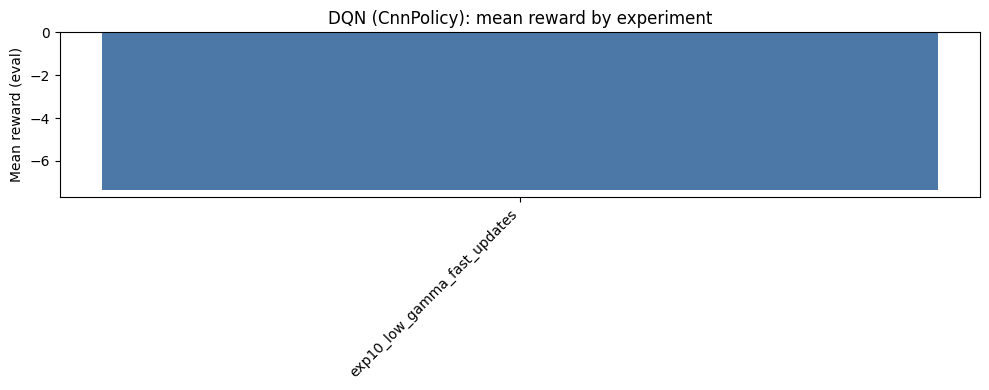

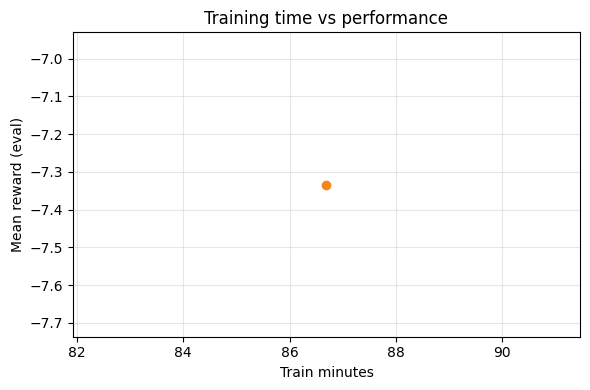

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Ensure results_df exists and is sorted by mean_reward
_df = results_df.copy()
if "mean_reward" in _df.columns:
    _df = _df.sort_values("mean_reward", ascending=False)

# Bar chart: mean_reward by experiment
plt.figure(figsize=(10, 4))
plt.bar(_df["name"], _df["mean_reward"], color="#4c78a8")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean reward (eval)")
plt.title("DQN (CnnPolicy): mean reward by experiment")
plt.tight_layout()
plt.show()

# Scatter: train_minutes vs mean_reward
if "train_minutes" in _df.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(_df["train_minutes"], _df["mean_reward"], color="#f58518")
    plt.xlabel("Train minutes")
    plt.ylabel("Mean reward (eval)")
    plt.title("Training time vs performance")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 6: Play the BEST saved model for the current experiment with on-screen rendering
import os, time
import gymnasium as gym
import ale_py  # ensure ALE namespace is registered
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

# Automatically use the current experiment name
current_exp_name = experiments[0]["name"]  # since you only run one at a time
BEST_MODEL_PATH = os.path.join("models", f"{current_exp_name}_best.zip")

N_EPISODES = 1
SEED = 42

if not os.path.isfile(BEST_MODEL_PATH):
    print("Best model not found:", BEST_MODEL_PATH)
    if os.path.isdir("models"):
        print("Available models:")
        for f in sorted(os.listdir("models")):
            if f.endswith(".zip"):
                print(" -", os.path.join("models", f))
else:
    # Create the environment with human rendering
    env = make_atari_env(ENV_ID, n_envs=1, seed=SEED, env_kwargs={"render_mode": "human"})
    env = VecFrameStack(env, n_stack=4)

    # Load and play
    model = DQN.load(BEST_MODEL_PATH, env=env)
    for ep in range(N_EPISODES):
        obs = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, rewards, dones, infos = env.step(action)
            ep_reward += float(rewards[0])
            done = bool(dones[0])
            time.sleep(1 / 60)  # ~60 FPS playback
        print(f"Episode {ep+1} return: {ep_reward:.2f}")
    env.close()


c:\Users\TestSolutions\Desktop\Deep-Q-Learning\venv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.65GB > 1.58GB
  warnings.warn(


Episode 1 return: -14.00
